# 1. Brand and MBTI Mapping
This code analyzes the relationship between brands and MBTI types by vectorizing text data, predicting brand preferences with a logistic regression model, performing sentiment analysis, and visualizing the results with a heatmap.

MBTI_Final         ENFJ   ENFP      ENTP  ESFJ  ESFP  ESTJ  ESTP      INFJ  \
brand                                                                        
Cartier             NaN  0.425  0.600000   NaN   NaN   1.0   NaN  0.242371   
Chanel              NaN    NaN       NaN   NaN   NaN   NaN   NaN  0.198602   
Dior                NaN  0.300       NaN  0.00   0.0   NaN   0.0  0.086860   
Gucci               NaN    NaN  0.766667   NaN   NaN   NaN   NaN  0.202451   
Louis Vuitton -0.433333  1.000       NaN   NaN   NaN   NaN   0.0  0.031771   
Prada               NaN    NaN       NaN  0.80   0.0   NaN   NaN  0.140051   
Ralph Lauren        NaN    NaN       NaN   NaN   0.0   NaN   NaN  0.276616   
Rolex               NaN    NaN  0.000000  0.25   0.6   NaN   NaN  0.120985   
Tiffany             NaN  0.000       NaN   NaN   0.0   NaN   NaN  0.037500   
Versace             NaN  0.250       NaN   NaN   NaN   NaN   NaN  0.212333   

MBTI_Final         INFP      INTJ      INTP      ISFJ      ISFP

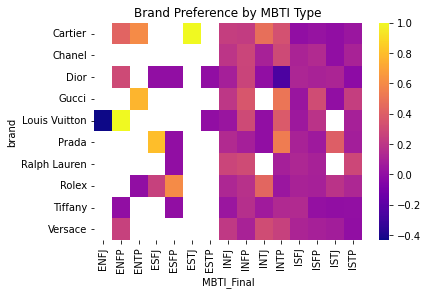

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/final_dataset.csv')
#handle missing values in the 'cleaned_text' column by replacing NaNs with an empty string
df['cleaned_text'] = df['cleaned_text'].fillna('')

#vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
#convert the cleaned text data into a matrix of TF-IDF features for model input
X = vectorizer.fit_transform(df['cleaned_text'])

#map brand names to numerical labels, ref: https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html
df['brand_label'] = df['brand'].astype('category').cat.codes

#split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['brand_label'], test_size=0.2, random_state=42)

#train a Logistic Regression model to predict brands
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions and evaluate the model
predictions = model.predict(X_test)

# perform sentiment analysis on the cleaned text data
df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# create a crosstab of brand preferences by MBTI type with average sentiment, ref: https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html
brand_mbti_crosstab = pd.crosstab(df['brand'], df['MBTI_Final'], values=df['sentiment'], aggfunc='mean')
print(brand_mbti_crosstab)

#visualize the relationship between brands and MBTI types using 'tab20' color map
sns.heatmap(brand_mbti_crosstab, cmap='plasma')
plt.title('Brand Preference by MBTI Type')
plt.show()

#create a crosstab of brand preferences by MBTI type
brand_mbti_crosstab = pd.crosstab(df['brand'], df['MBTI_Final'])
brand_mbti_crosstab.to_csv('data/brand_mbti_mapping.csv')


# 2. Predicting MBTI, Recommending Brands, and Visualizing Sentiment
This script predicts the user's MBTI type based on text input, recommends relevant brands, performs sentiment analysis, and visualizes the sentiment as a color.

Predicted MBTI Type: INFP
Recommended Brands: Cartier
Sentiment Polarity: 0.5, Subjectivity: 0.6
Extracted Topics: luxury love high


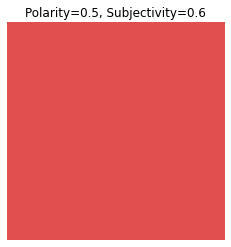

In [38]:
import joblib
import pandas as pd
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import colorsys

#load models, vectorizer, and brand mapping data
models = {dim: joblib.load(f'saved_models/svc_model_{dim}.pkl') for dim in ['EI', 'NS', 'FT', 'PJ']}
vectorizer = joblib.load('saved_models/tfidf_vectorizer.pkl')
brand_mbti_mapping = pd.read_csv('data/brand_mbti_mapping.csv')

#sentiment analysis function using TextBlob,ref:https://textblob.readthedocs.io/en/dev/
def analyze_sentiment(text):
    #create a TextBlob object to process the text
    blob = TextBlob(text)
    #return the polarity and subjectivity scores of the text
    return blob.sentiment.polarity, blob.sentiment.subjectivity

#topic extraction function using LDA,ref:https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
def extract_topics(text, n_topics=1, n_words=3):
    #create a CountVectorizer for text
    count_vectorizer = CountVectorizer(stop_words='english')
    #convert input text to a document-term matrix
    X_counts = count_vectorizer.fit_transform([text])
    #fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42).fit(X_counts)
    #etract the most important words from each topic
    return [" ".join([count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-n_words -1:-1]]) for topic in lda.components_]

#brand recommendation function based on MBTI prediction
def recommend_brand(user_input, models, vectorizer, brand_mapping):
    #vectorize user input text
    user_input_vectorized = vectorizer.transform([user_input])
    #predict MBTI type using the models for each dimension 
    predicted_mbti = "".join(model.predict(user_input_vectorized)[0] for model in models.values())
    #sort brands by relevance to the predicted MBTI type
    recommended_brands = brand_mapping[['brand', predicted_mbti]].sort_values(by=predicted_mbti, ascending=False)['brand'].values
    return predicted_mbti, recommended_brands

#function to map sentiment analysis results to an RGB color
def sentiment_to_color(polarity, subjectivity):
    #calculate lightness based on polarity
    lightness = 0.3 + (polarity + 1) / 2 * 0.4
    #calculate saturation based on subjectivity
    saturation = 0.3 + subjectivity * 0.7
    #convert HLS to RGB, using red hue,ref:# ref: https://docs.python.org/3/library/colorsys.html#colorsys.hls_to_rgb
    r, g, b = colorsys.hls_to_rgb(0, lightness, saturation)
    return r, g, b

#test user input text
user_input = "I love high-end fashion and luxury brands."

#call functions to get results
predicted_mbti, recommended_brands = recommend_brand(user_input, models, vectorizer, brand_mbti_mapping)
sentiment_polarity, sentiment_subjectivity = analyze_sentiment(user_input)
topics = extract_topics(user_input)

print(f"Predicted MBTI Type: {predicted_mbti}")
print(f"Recommended Brands: {', '.join(recommended_brands[:1])}")
print(f"Sentiment Polarity: {sentiment_polarity}, Subjectivity: {sentiment_subjectivity}")
print(f"Extracted Topics: {', '.join(topics)}")
color = sentiment_to_color(sentiment_polarity, sentiment_subjectivity)
plt.imshow([[color]])
plt.title(f"Polarity={sentiment_polarity}, Subjectivity={sentiment_subjectivity}")
plt.axis('off')
plt.show()